# Reddit Depression Detection

Improvements
1. Autocorrect
2. Spell Check
3. Grammar Check

## Initialization

### Import Statements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Import Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Dataset Transformation

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})
df.head()

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_16188\3534510445.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


### Balanced Sampling

In [4]:
df = pd.concat([df[df['class']==1].head(15000), df[df['class']==0].tail(15000)],ignore_index=True)
# df[df['class']=='non-suicide'].tail(5000)

### Check Dimensions

In [5]:
df.shape

(30000, 2)

### Label Counts

In [6]:
df['class'].value_counts()

class
1    15000
0    15000
Name: count, dtype: int64

##### Balanced Dataset

### Remove Null/Duplicated Values

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(30000, 2)

## Preprocessing

### Demojification and Tag Removal

Removal of Hyperlinks, Emojis and r/ tokens

In [8]:
import re
df['text'] = [re.sub(r"[^a-z A-Z 0-9 \,\.!@#$%^&*_\(\)-=+\{\}\[\]:;'<>/?|`]", '', str(sentence)) for sentence in df['text']]    # Removes Emojis
df['text'] = [re.sub(r"https?://\S+", '', str(sentence)) for sentence in df['text']]                                            # Removes Hyperlinks
df['text'] = [re.sub(r"\br/\S+", '', str(sentence)) for sentence in df['text']]                                                 # Removes r/ Reddit Communities

### Lemmatization and Lowering

In [9]:
# python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner','parser'])

# 5m 31s execution time
def preprocess(sentence):
    doc = nlp(sentence)
    lemmatized_tokens = [token.lemma_ for token in doc if token.pos_ != 'PUNCT' and not token.is_stop]
    return ' '.join(token for token in lemmatized_tokens).strip()

# 3m 12s execution time
def batch_preprocess(sentences):
    lemmatized_texts = (' '.join(token.lemma_.lower() for token in doc if token.pos_ != 'PUNCT' and not token.is_stop).strip() for doc in nlp.pipe(sentences, batch_size=500, disable=['parser', 'ner'], n_process=2))
    return lemmatized_texts

df['text_lemma'] = list(batch_preprocess(df['text'].tolist()))

C:\Users\Rishabh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Building

### TF-IDF Vectorizing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords.words('english'), ngram_range=(1,2))
X_train, X_test, Y_train, Y_test = train_test_split(df['text_lemma'], df['class'], test_size=0.2, random_state=42)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Model Training

#### XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
model = XGBClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2952
           1       0.93      0.89      0.91      3048

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



#### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
model = RandomForestClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2952
           1       0.90      0.89      0.90      3048

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



#### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2952
           1       0.94      0.91      0.92      3048

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



In [14]:
X_train_vectorized.shape

(24000, 10000)

### Deep Learning - ANN

In [15]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Embedding
model = Sequential()
model.add(Dense(128, input_dim=X_train_vectorized.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
hist = model.fit(X_train_vectorized.toarray(), Y_train, epochs=5, batch_size=2, validation_split=0.2)




Epoch 1/5


9600/9600 [==============================] - 162s 17ms/step - loss: 0.2292 - accuracy: 0.9087 - val_loss: 0.2038 - val_accuracy: 0.9215
Epoch 2/5
9600/9600 [==============================] - 393s 41ms/step - loss: 0.1226 - accuracy: 0.9539 - val_loss: 0.2364 - val_accuracy: 0.9142
Epoch 3/5
9600/9600 [==============================] - 187s 19ms/step - loss: 0.0808 - accuracy: 0.9683 - val_loss: 0.3037 - val_accuracy: 0.9075
Epoch 4/5
9600/9600 [==============================] - 193s 20ms/step - loss: 0.0564 - accuracy: 0.9762 - val_loss: 0.3866 - val_accuracy: 0.9062
Epoch 5/5
9600/9600 [==============================] - 256s 27ms/step - loss: 0.0396 - accuracy: 0.9827 - val_loss: 0.5407 - val_accuracy: 0.9038


### Model Accuracy

In [20]:
Y_prob = model.predict(X_test_vectorized.toarray())
Y_pred = np.where(Y_prob>0.5, 1, 0)
model.evaluate(X_test_vectorized.toarray(), Y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.5345 - accuracy: 0.9090


[0.5345124006271362, 0.9089999794960022]

### Accuracy Plots

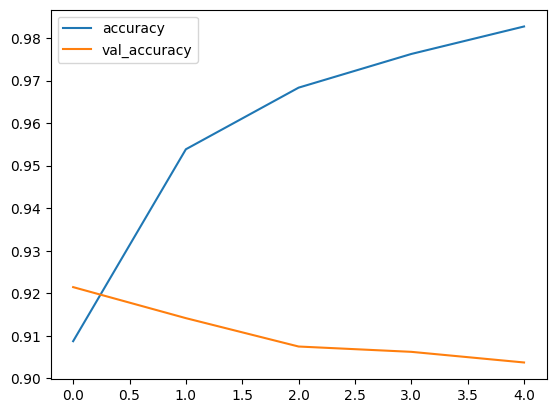

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'],loc='best')
plt.show()

### Loss Plots

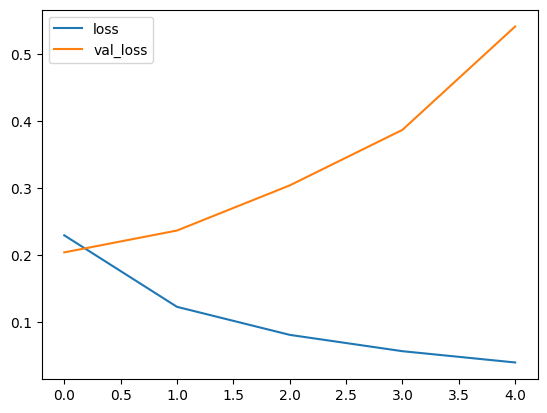

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'],loc='best')
plt.show()

### Confusion Matrix

In [24]:
from tensorflow import math
math.confusion_matrix(Y_test, Y_pred) 
plt.show()